In [1]:
# Reference: https://lifewithdata.com/2022/08/29/how-to-create-a-sankey-diagram-in-plotly-python/

import pandas as pd
import requests
import plotly.graph_objects as go
import duckdb
import plotly.io as pio
pio.renderers.default = "nteract"
import plotly.express as px
import matplotlib.colors

df_ = pd.read_parquet('https://storage.data.gov.my/dashboards/prasarana_timeseries.parquet')




In [2]:
# !pip install plotly matplotlib seaborn

## Plotting Sankey

In [3]:
df1 = duckdb.sql("""
          SELECT
           concat(origin, ' (Origin)') as train_origin, 
           concat(destination, ' (Destination)') as train_destination,
           sum(passengers) as total_passengers
          FROM df_
          WHERE origin <> destination
               AND origin not ilike '%all station%'
               AND destination not ilike '%all station%'
               AND frequency = 'monthly'
          GROUP BY ALL

""").df()

df1.head()

,train_origin,train_destination,total_passengers
0,AG01: Sentul Timur (Origin),AG07: Masjid Jamek (Destination),18130.0
1,AG01: Sentul Timur (Origin),AG12: Miharja (Destination),2710.0
2,AG01: Sentul Timur (Origin),AG18: Ampang (Destination),7323.0
3,AG01: Sentul Timur (Origin),KG05: Kwasa Sentral (Destination),1197.0
4,AG01: Sentul Timur (Origin),KG23: Taman Pertama (Destination),671.0


In [4]:
df1 = duckdb.sql("""
           SELECT *
           FROM df1
           ORDER BY total_passengers desc
           LIMIT 30
           
           """).df()

In [5]:
#for using with 'label' parameter in plotly 
#https://sparkbyexamples.com/pandas/pandas-find-unique-values-from-columns
unique_source_target = list(pd.unique(df1[['train_origin', 'train_destination']].values.ravel('K')))

link_opacity = 0.3  # Set a value from 0 to 1: the lower, the more transparent the links

# Define a list of hex color codes for nodes
node_colors = px.colors.qualitative.G10  

# Convert list of colors to RGB format to override default gray link colors
colors = [matplotlib.colors.to_rgb(i) for i in node_colors]  

# Create objects to hold node/label and link colors
label_colors, df1["link_c"] = [], str(0)

# Loop through all the labels to specify color and to use label indices
c, max_colors = 0, len(colors)  # To loop through the colors array
for l in range(len(unique_source_target)):
    label_colors.append(colors[c])
    link_color = colors[c] + (link_opacity,)  # Make link more transparent than the node
    df1.loc[df1['train_origin'] == unique_source_target[l], "link_c"] = "rgba" + str(link_color)
    # df1 = df1.replace({unique_source_target[l]: l})  # Replace node labels with the label's index
    if c == max_colors - 1:
        c = 0
    else:
        c += 1

# Convert colors into RGB string format for Plotly
label_colors = ["rgb" + str(i) for i in label_colors]

#converting full dataframe as list for using with in plotly
links_dict = df1.to_dict(orient='list')


#for assigning unique number to each source and target
mapping_dict = {k: v for v, k in enumerate(unique_source_target)}

#mapping of full data
df1['train_origin'] = df1['train_origin'].map(mapping_dict)
df1['train_destination'] = df1['train_destination'].map(mapping_dict)


links_dict = df1.to_dict(orient='list')

In [6]:

#Sankey Diagram Code 
fig = go.Figure(data=[go.Sankey(
    arrangement = "snap",
    node = dict(
      pad = 25,
      thickness = 50,
      line = dict(color = "black", width = 0.7),
      label = unique_source_target,
      color = label_colors
      
    ),
    link = dict(
      arrowlen=15,
      source = links_dict["train_origin"],
      target = links_dict["train_destination"],
      value = links_dict["total_passengers"],
      color = links_dict["link_c"]
  
  ))])

fig.update_layout(title_text="Total Passengers To-From Stations")

# fig.update_traces(node_color = color_for_nodes, link_color = color_for_links)
fig.show()

In [7]:
# !pip install --upgrade nbformat

## Plotting Passenger Growth Over Time

In [8]:
df2 = duckdb.sql("""
            SELECT 
                concat(origin, ' (Origin)') as train_origin, 
                date,
                SUM(passengers) as total_passengers
            FROM df_
            WHERE origin <> destination
               AND origin not ilike '%all station%'
               AND destination not ilike '%all station%'
               AND frequency = 'daily'
               and date > '2023-07-01'
               and date < '2024-08-01'
               and origin not like '%BRT%'
           GROUP BY ALL

           """).df()

df2['line_name'] = [x[:2] for x in df2['train_origin']]

In [9]:
df2 = duckdb.sql("""
            SELECT 
                *,
                CASE 
                    WHEN LAG(total_passengers) OVER(PARTITION BY train_origin ORDER BY date ASC) IS NULL THEN 0
                    ELSE ROUND( (LAG(total_passengers) OVER(PARTITION BY train_origin ORDER BY date ASC) - total_passengers  )  * 100 / total_passengers , 2)
                    END AS mom_passenger_change
            FROM df2

           """).df()

df2.head(10)

,train_origin,date,total_passengers,line_name,mom_passenger_change
0,AG15: Pandan Indah (Origin),2024-06-01,2021.0,AG,0.00
1,AG15: Pandan Indah (Origin),2024-06-02,1641.0,AG,23.16
2,AG15: Pandan Indah (Origin),2024-06-03,1448.0,AG,13.33
3,AG15: Pandan Indah (Origin),2024-06-04,2560.0,AG,-43.44
4,AG15: Pandan Indah (Origin),2024-06-05,2628.0,AG,-2.59
5,AG15: Pandan Indah (Origin),2024-06-06,2622.0,AG,0.23
6,AG15: Pandan Indah (Origin),2024-06-07,2631.0,AG,-0.34
7,AG15: Pandan Indah (Origin),2024-06-08,1806.0,AG,45.68
8,AG15: Pandan Indah (Origin),2024-06-09,1539.0,AG,17.35
9,AG15: Pandan Indah (Origin),2024-06-10,2692.0,AG,-42.83


In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
df2[df2['line_name'] == 'AG']

,train_origin,date,total_passengers,line_name,mom_passenger_change
0,AG15: Pandan Indah (Origin),2024-06-01,2021.0,AG,0.00
1,AG15: Pandan Indah (Origin),2024-06-02,1641.0,AG,23.16
2,AG15: Pandan Indah (Origin),2024-06-03,1448.0,AG,13.33
3,AG15: Pandan Indah (Origin),2024-06-04,2560.0,AG,-43.44
4,AG15: Pandan Indah (Origin),2024-06-05,2628.0,AG,-2.59
...,...,...,...,...,...
7291,AG09: Hang Tuah (Origin),2024-07-23,4044.0,AG,-0.20
7292,AG09: Hang Tuah (Origin),2024-07-24,4004.0,AG,1.00
7293,AG09: Hang Tuah (Origin),2024-07-25,3969.0,AG,0.88
7294,AG09: Hang Tuah (Origin),2024-07-26,4231.0,AG,-6.19


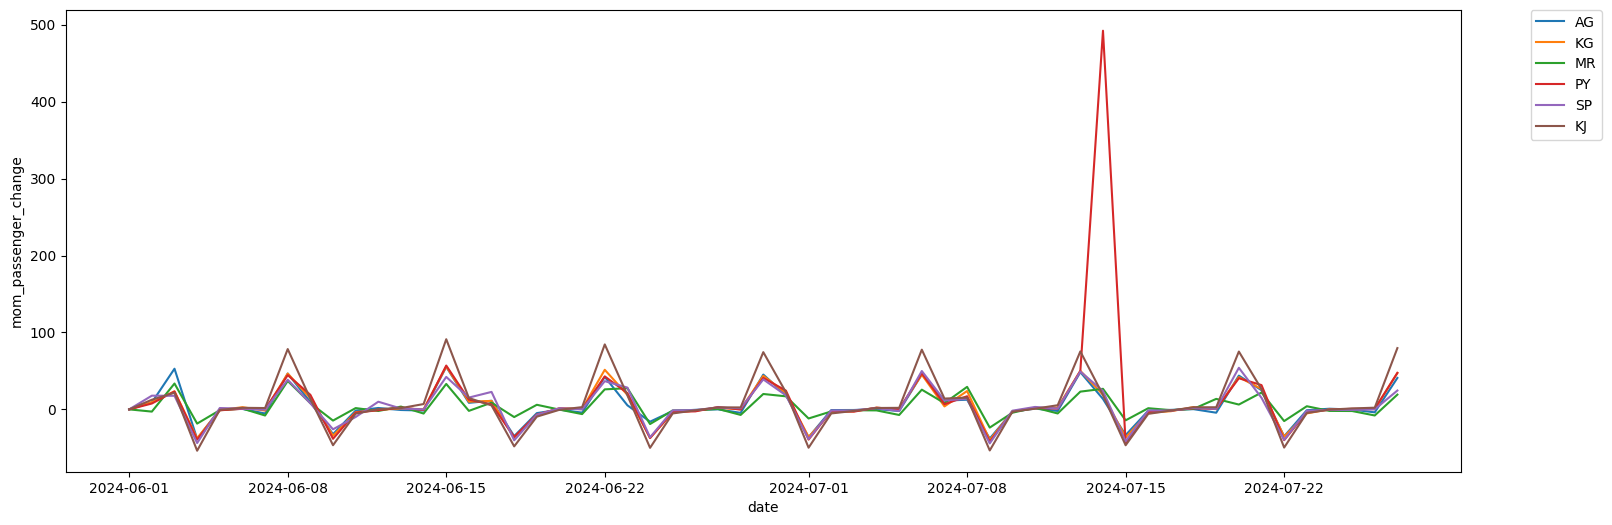

In [16]:
plt.figure(figsize=(18,6))
sns.lineplot(data=df2, x='date', y='mom_passenger_change', hue='line_name', errorbar=None)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
